##Import

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [ ]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices()
print(physical_devices)


In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


In [ ]:
import re
import pandas as pd
import numpy as np
import keras

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from keras.layers import Embedding, SpatialDropout1D, Dropout

from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau

##Data

In [ ]:
df = pd.read_csv('IMDB_dataset.csv')
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [ ]:
def map_overall(value):
    if value == 'positive':
        return 1
    elif value == 'negative':
      return 0

df['sentiment'] = df['sentiment'].apply(map_overall)

In [ ]:
def remove_nan_values(dataframe):
    cleaned_dataframe = dataframe.dropna()
    return cleaned_dataframe

df = remove_nan_values(df)

In [ ]:
df['sentiment'].value_counts()

sentiment
1    25000
0    25000
Name: count, dtype: int64

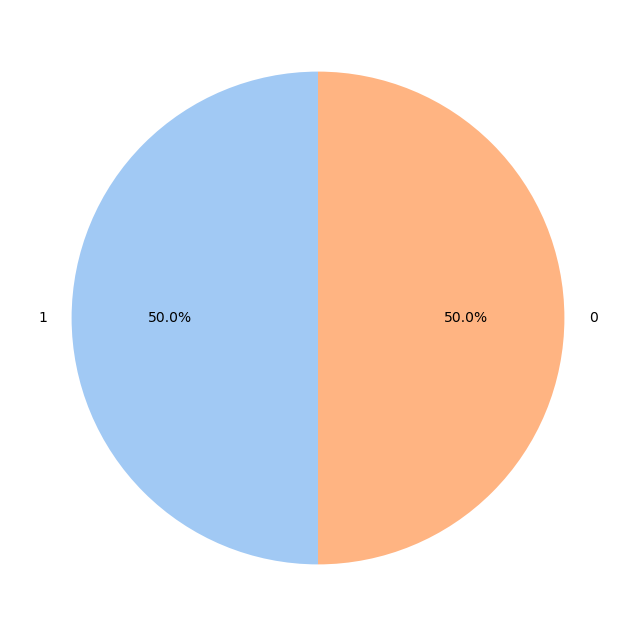

In [ ]:
def plot(df):
  plt.figure(figsize=(8,8))
  sen_counts = df['sentiment'].value_counts()
  plt.pie(sen_counts, labels=sen_counts.index, autopct = '%1.1f%%', colors=sns.color_palette("pastel"), startangle=90)
  plt.show()

plot(df)

In [ ]:
df.isna().any().any()

False

In [ ]:
tag = re.compile(r'<[^>]+>')
def remove_tags(text):
    return tag.sub('', text)

nltk.download('stopwords')

def preprocess(text):
    sen = text.lower()
    sen = remove_tags(sen)
    sen = re.sub('[^a-zA-Z]', ' ', sen)
    sen = re.sub(r'\s+[a-zA-Z]\s+', ' ', sen)
    sen = re.sub(r'\s+', ' ', sen)
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sen = pattern.sub('', sen)
    return sen

In [ ]:
nltk.download('wordnet')
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
  st =''
  for w in w_tokenizer.tokenize(text):
    st = st + lemmatizer.lemmatize(w) + ' '
  return st.strip()


In [ ]:
X = []
sen = list(df['review'])
for s in sen:
    prep1 = preprocess(s)
    prep2 = lemmatize_text(prep1)
    X.append(prep2)

In [ ]:
X[0]

'one reviewer mentioned watching oz episode hooked right exactly happened first thing struck oz brutality unflinching scene violence set right word go trust show faint hearted timid show pull punch regard drug sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focus mainly emerald city experimental section prison cell glass front face inwards privacy high agenda em city home many aryan muslim gangsta latino christian italian irish scuffle death stare dodgy dealing shady agreement never far away would say main appeal show due fact go show dare forget pretty picture painted mainstream audience forget charm forget romance oz mess around first episode ever saw struck nasty surreal say ready watched developed taste oz got accustomed high level graphic violence violence injustice crooked guard sold nickel inmate kill order get away well mannered middle class inmate turned prison bitch due lack street skill prison experience watching oz m

In [ ]:
clean_df = pd.DataFrame(X, columns=['review'])

In [ ]:
clean_df['sentiment'] = df['sentiment']

In [ ]:
clean_df.to_csv('clean_data.csv', index=False)

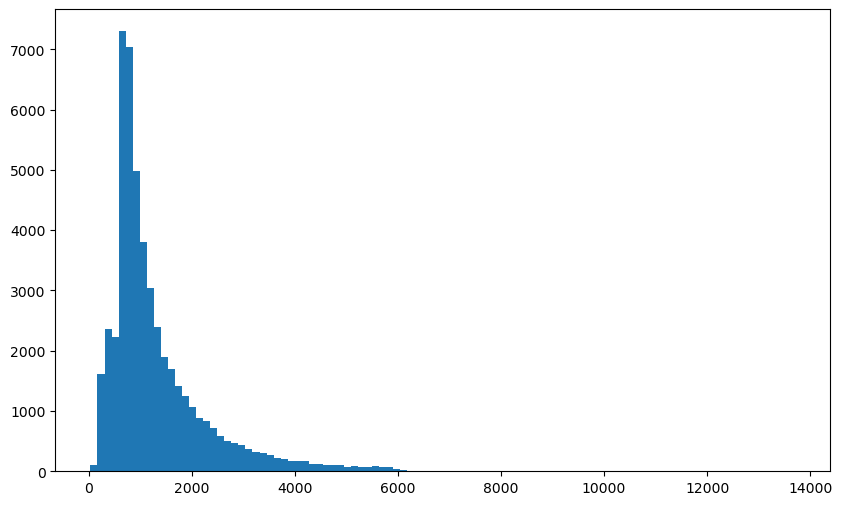

In [ ]:
max_len = df['review'].str.len()
plt.figure(figsize = (10,6))
plt.hist(max_len, bins= 100)
plt.show()


In [ ]:
y = np.array(df['sentiment'])

##Encoding

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
y_test

array([1, 1, 0, ..., 1, 0, 1])

In [ ]:
y_test.shape

(10000,)

In [ ]:
#Tokenize sentences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

In [ ]:
#Hyperparameters
vocab_size = len(word_index) + 1
print(vocab_size)
oov_tok = ''
embedding_dim = 100
max_length = 100
padding_type = 'post'
trunc_type = 'post'

83492


In [ ]:
train_padded = pad_sequences(train_sequences, padding = 'post', maxlen = max_length)
test_padded = pad_sequences(test_sequences, padding = 'post', maxlen = max_length)

In [ ]:
train_padded

array([[28962,   109,   112, ...,   108,   124,  3490],
       [  206,    34,    95, ...,    27,  1524,    32],
       [ 1168,    33,     8, ...,     0,     0,     0],
       ...,
       [  649,     3,   275, ...,     0,     0,     0],
       [  221,    89,   551, ...,     0,     0,     0],
       [  416,     1,   164, ...,     0,     0,     0]], dtype=int32)

In [ ]:
print('train padded shape', train_padded.shape)
print('test padded shape', test_padded.shape)

train padded shape (40000, 100)
test padded shape (10000, 100)


In [ ]:
from numpy import asarray
from numpy import zeros

emb_dict = dict()
glove_file = open('a2_glove.6B.100d.txt', encoding = 'utf8')

for line in glove_file:
    records = line.split()
    word = records[0]
    vec_dims = asarray(records[1:], dtype='float32')
    emb_dict[word] = vec_dims
glove_file.close()

In [ ]:
emb_dict

In [ ]:
emb_matrix = zeros((vocab_size, 100))
for w, i in word_index.items():
    emb_vec = emb_dict.get(w)
    if emb_vec is not None:
        emb_matrix[i] = emb_vec

In [ ]:
emb_matrix

##Building a model

In [ ]:
with tf.device('/CPU:0'):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, weights=[emb_matrix], trainable=False),
        Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)),
        #Bidirectional(LSTM(256, dropout=0.3, recurrent_dropout=0.2)),
        LSTM(64),
        #Dense(128, activation='relu', kernel_regularizer=l2(0.02)),
        #Dropout(0.4),
        Dense(32, activation='relu'),
        Dropout(0.4),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_16 (Embedding)        │ ?                      │     8,349,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_17                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,349,200 (31.85 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 8,349,200 (31.85 MB)

In [ ]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss',
                                 factor=0.3,
                                 patience=2,
                                 min_lr=1e-6,
                                 verbose=1)

##Model Training and Evaluation

In [ ]:
num_epochs=15
with tf.device('/CPU:0'):
    history = model.fit(train_padded, y_train,
                epochs=num_epochs, batch_size=128,  verbose=1, validation_split=0.2, callbacks=[lr_scheduler])

Epoch 1/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 35s 136ms/step - accuracy: 0.6326 - loss: 0.6404 - val_accuracy: 0.7701 - val_loss: 0.5136 - learning_rate: 0.0010
Epoch 2/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 37s 149ms/step - accuracy: 0.7247 - loss: 0.5628 - val_accuracy: 0.7921 - val_loss: 0.4634 - learning_rate: 0.0010
Epoch 3/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 38s 154ms/step - accuracy: 0.7629 - loss: 0.5185 - val_accuracy: 0.7971 - val_loss: 0.4551 - learning_rate: 0.0010
Epoch 4/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 39s 155ms/step - accuracy: 0.7801 - loss: 0.4877 - val_accuracy: 0.8163 - val_loss: 0.4054 - learning_rate: 0.0010
Epoch 5/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 40s 160ms/step - accuracy: 0.8002 - loss: 0.4421 - val_accuracy: 0.8214 - val_loss: 0.3857 - learning_rate: 0.0010
Epoch 6/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 163ms/step - accuracy: 0.8196 - loss: 0.4055 - val_accuracy: 0.8462 - val_loss: 0.3530 - learning_rate: 0.0010
Epoch 7/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 163ms/step - accuracy: 0.8

In [ ]:
prediction = model.predict(test_padded)
predicted_labels = np.round(prediction).astype(int)

print("Accuracy of prediction on test set : ", accuracy_score(y_test,predicted_labels))
print("F1 of prediction on test set : ", f1_score(y_test,predicted_labels, average=None))
print("Precision of prediction on test set : ", precision_score(y_test,predicted_labels, average=None))
print("Recall of prediction on test set : ", recall_score(y_test,predicted_labels, average=None))

313/313 ━━━━━━━━━━━━━━━━━━━━ 138s 439ms/step
Accuracy of prediction on test set :  0.8802
F1 of prediction on test set :  [0.87735463 0.88291634]
Precision of prediction on test set :  [0.89140836 0.86982476]
Recall of prediction on test set :  [0.86373715 0.89640802]


In [ ]:
prediction = model.predict(test_padded)
predicted_labels = np.round(prediction).astype(int)

print("Accuracy of prediction on test set : ", accuracy_score(y_test,predicted_labels))
print("F1 of prediction on test set : ", f1_score(y_test,predicted_labels, average=None))
print("Precision of prediction on test set : ", precision_score(y_test,predicted_labels, average=None))
print("Recall of prediction on test set : ", recall_score(y_test,predicted_labels, average=None))

313/313 ━━━━━━━━━━━━━━━━━━━━ 134s 427ms/step
Accuracy of prediction on test set :  0.876
F1 of prediction on test set :  [0.87802479 0.87390685]
Precision of prediction on test set :  [0.85744476 0.89614181]
Recall of prediction on test set :  [0.89961701 0.85274856]


In [ ]:
model.save('model7.keras')

In [ ]:
model = load_model('model7.keras')
with tf.device('/CPU:0'):
    model_history = model.fit(train_padded, y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.2, callbacks=[lr_scheduler])


Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 47s 185ms/step - accuracy: 0.8916 - loss: 0.2663 - val_accuracy: 0.8736 - val_loss: 0.2877 - learning_rate: 0.0010
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 47s 186ms/step - accuracy: 0.8939 - loss: 0.2579 - val_accuracy: 0.8781 - val_loss: 0.3004 - learning_rate: 0.0010
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.8987 - loss: 0.2509
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
250/250 ━━━━━━━━━━━━━━━━━━━━ 46s 184ms/step - accuracy: 0.8987 - loss: 0.2509 - val_accuracy: 0.8774 - val_loss: 0.2937 - learning_rate: 0.0010
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 47s 186ms/step - accuracy: 0.9117 - loss: 0.2232 - val_accuracy: 0.8788 - val_loss: 0.2983 - learning_rate: 3.0000e-04
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9165 - loss: 0.2150
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
250/250 ━━━━━━━━━━━━━━━━━━━━ 47s 186ms/step - accuracy: 0.9165 -

In [ ]:
prediction = model.predict(test_padded)
predicted_labels = np.round(prediction).astype(int)

print("Accuracy of prediction on test set : ", accuracy_score(y_test,predicted_labels))
print("F1 of prediction on test set : ", f1_score(y_test,predicted_labels, average=None))
print("Precision of prediction on test set : ", precision_score(y_test,predicted_labels, average=None))
print("Recall of prediction on test set : ", recall_score(y_test,predicted_labels, average=None))

313/313 ━━━━━━━━━━━━━━━━━━━━ 159s 507ms/step
Accuracy of prediction on test set :  0.8633
F1 of prediction on test set :  [0.85992417 0.86651694]
Precision of prediction on test set :  [0.87453105 0.85294118]
Recall of prediction on test set :  [0.84579722 0.88053185]


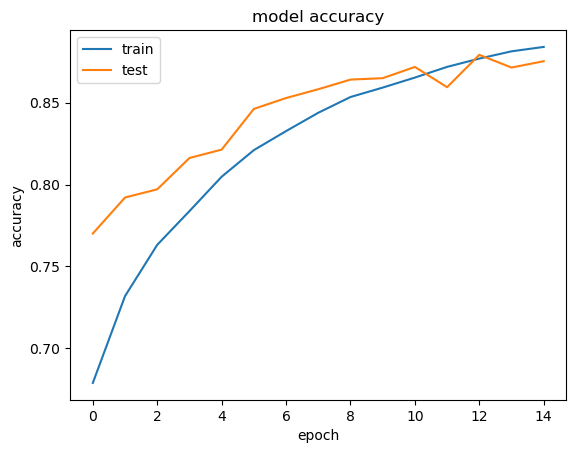

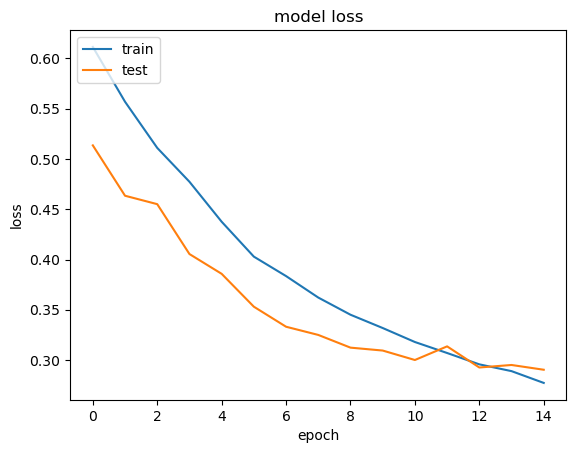

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()